# Présence du monde de la recherche dans les projets Open Source de Machine Learning : ces projets sont-ils faits par des chercheurs ?

Dans le cadre de notre étude, nous nous interrogeons sur la participation du monde de la recherche au sein des projets Open Source de Machine Learning.

Nos hypothèses sur la question sont les suivantes :
* Les contributeurs ne sont pas majoritairement des chercheurs.
* Les contributions viennent majoritairement de contributeurs-chercheurs (en nombre de *commits* et en nombre de lignes).
* Les contributeurs-chercheurs sont les contributeurs qui contribuent le plus individuellement (en nombre de *commits* et en nombre de lignes).
* La majorité des *commits* ajoutant des fonctionnalités proviennent de contributeurs-chercheurs.

Les hypothèses de travail que nous posons concernent la bonne foi des contributeurs dans les informations de *commit*. En particulier :
* Le nom/prénom est celui de l'auteur.
* L'adresse mail appartient à l'auteur.

Pour étudier ces hypothèses et tenter de les réfuter, nous allons nous pencher sur les contributions de trois projets :
* [Scikit-Learn](http://scikit-learn.org/stable/) ([dépôt GitHub](https://github.com/scikit-learn/scikit-learn)).
* [Keras](https://keras.io/) ([dépôt GitHub](https://github.com/keras-team/keras)).
* [Theano](http://deeplearning.net/software/theano/) ([dépôt GitHub](https://github.com/Theano/Theano)).

Les données que nous allons exploiter dans ce document sont issues d'une extraction depuis leur dépôt Git respectif grâce à Repodriller. L'étude est reproductible avec le code disponible sur [notre dépôt GitHub](https://github.com/AntoineAube/reace-study).

In [1]:
# Let us import some awesome libraries!
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scholarly
import progressbar
import os.path
import math

%matplotlib inline

# Just a bit of style. ;)
sns.set_palette(sns.color_palette('hls', 8))

In [2]:
# Let us load the datasets.
scikit_dataset = pd.read_csv('study-results/scikit-learn/exploration.csv')
keras_dataset = pd.read_csv('study-results/keras/exploration.csv')
theano_dataset = pd.read_csv('study-results/theano/exploration.csv')

# For example, let us take a look to the Scikit-Learn dataset.
scikit_dataset.sample(5)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES
9133,a633b28e2b9556d963d09a727d42828b6bf51623,Andy,amueller@ais.uni-bonn.de,1,1334337221000,101,14,0
518,35e6a87c48a753033722f4a40204d510cc994cda,Fabian Pedregosa,fabian.pedregosa@inria.fr,1,1268399627000,8,9,0
4482,d124bde78689037b17e7a70af4c46dd282d24fbc,Alexandre Gramfort,alexandre.gramfort@inria.fr,2,1308095058000,8,0,0
9803,4918c9cc9d164e65282410c952371566e4bb9cec,Yaroslav Halchenko,debian@onerussian.com,2,1341415292000,20,0,0
5339,4121347f943c4f958b657c53915a30ad59d5dc8c,Brian Holt,bdholt1@gmail.com,1,1312904465000,16,9,0


## Quels sont les contributeurs-chercheurs ?

Nous considérons que les contributeurs "chercheurs" sont les contributeurs qui écrivent des articles scientifiques et dont la profession est de faire progresser la recherche, sans discrimination entre les chercheurs académiques et les chercheurs de l'industrie.

Pour répondre à cette question, nous avons pensé à deux approches pour classifier les contributeurs selon qu'ils sont chercheurs ou pas, et les avons mises en oeuvre :
* Utiliser le domaine de leur adresse mail : si le domaine de l'adresse appartient à une université ou bien spécifiquement à un chercheur, alors nous considérons que le contributeur est un chercheur. Si le domaine n'est pas celui d'un chercheur, on ne peut rien déduire.
* Chercher l'existence de l'auteur dans un moteur de recherche d'articles scientifiques : s'il contient le profil du contributeur, alors il est considéré chercheur. Si la recherche aboutit à aucun résultat, alors le contributeur n'est pas chercheur.

Nous nous attendons à une sélection plus dure avec la seconde approche (tout moteur de recherche ne recense pas tous les articles, ...) mais également plus rigoureuse (généralement, un contributeur non-chercheur ne publie pas d'article scientifique). La première approche est très peu précise (on ne peut rien déduire d'un domaine générique comme *gmail.com* donc il y aura inévitablement des faux négatifs).

In [3]:
def get_contributors(dataset):
    return dataset[['AUTHOR_NAME', 'AUTHOR_EMAIL']].drop_duplicates()

scikit_contributors = get_contributors(scikit_dataset)
keras_contributors = get_contributors(keras_dataset)
theano_contributors = get_contributors(theano_dataset)

all_contributors = scikit_contributors.merge(keras_contributors, how = 'outer').merge(theano_contributors, how = 'outer')

# Load the previously computed contributors and merge for the already known ones.
if os.path.isfile('study-results/contributors.csv'):
    computed_contributors = pd.read_csv('study-results/contributors.csv')
    all_contributors = all_contributors.merge(computed_contributors, how = 'outer')
else:
    all_contributors['HAS_RESEARCHER_EMAIL'] = np.NaN
    all_contributors['HAS_PUBLICATIONS'] = np.NaN
    
all_contributors.sample(5)

,AUTHOR_NAME,AUTHOR_EMAIL,HAS_RESEARCHER_EMAIL,HAS_PUBLICATIONS
1409,Zhen Wang,nehz@users.noreply.github.com,False,NaN
149,Udi Weinsberg,udi.weinsberg@technicolor.com,False,True
2445,bscellier,bscellier@users.noreply.github.com,False,False
255,Szabo Roland,rolisz@gmail.com,False,True
1895,Jonathan DEKHTIAR,DEKHTIARJonathan@users.noreply.github.com,False,NaN


### Approche exploitant les adresses mail

Nous étudions le domaine des adresses mail dans le but de déterminer si chaque adresse appartient à un chercheur ou non.

Nous procédons avec une liste blanche de domaines dont nous jugeons les utilisateurs être des chercheurs.

La constitution de cette liste est fastidieuse car manuelle, mais nous n'avons pas vraiment le choix. La nature manuelle de ce travail implique aussi qu'elle est sensibles aux erreurs humaines...

In [4]:
def address_domain(address):
    split = address.split('@')
    
    if len(split) == 2:
        return split[1]
    else:
        return address
    
researcher_domains = ['inria.fr', 'cnes.fr', 'normalesup.org', 'ensta.org', 'jnphilipp.org',
                    'vene.ro', 'cern.ch', 'uva.nl', 'cea.fr', 'heig-vd.ch', 'wxs.ca', 'smerity.com',
                    'nsup.org', 'esciencecenter.nl', 'centraliens.net', 'acm.org', 'fu-berlin.de', 
                    'fit.vutbr.cz', 'hec.ca', 'barvinograd.com', 'jakelee.net', 'maluuba.com',
                    'nicta.com.au', 'poli.ufrj.br', 'barkalov.ru', 'allenai.org', 'usherbrooke.ca',
                    'taehoonlee.com', 'bioinf.jku.at', 'nerdluecht.de', 'yosinski.com', 'tum.de',
                    'enlnt.com', 'kottalam.net', 'jan-schlueter.de', 'iupr.com', 'uoguelph.ca',
                    'marcodena.it', 'esimon.eu', 'stophr.be', 'jan-matthis.de', 'josephpcohen.com',
                    'cwi.nl']
researcher_domains_ends = ['edu', 'ens-cachan.fr', 'intra.cea.fr', 'ntnu.no', 'umontreal.ca', 'mcgill.ca', 'epita.fr']
researcher_domains_contents = ['.ca.', 'research', '.ac.', '.uu.', 'edu', 'student', 'uni', 'etu']

def is_researcher_address(domain):
    for end in researcher_domains_ends:
        if domain.endswith(end):
            return True
    
    for content in researcher_domains_contents:
        if content in domain:
            return True
        
    return domain in researcher_domains

all_contributors['HAS_RESEARCHER_EMAIL'] = all_contributors['AUTHOR_EMAIL'].apply(address_domain).apply(is_researcher_address)

print('The approach with the mail addresses concluded that', len(all_contributors[all_contributors['HAS_RESEARCHER_EMAIL'] == True]), 'contributors (out of', len(all_contributors), 'contributors) are researchers.')

The approach with the mail addresses concluded that 355 contributors (out of 2520 contributors) are researchers.


### Approche avec un moteur de recherche d'articles scientifiques

Nous cherchons le nom des contributeurs sur [Google Scholar](https://scholar.google.fr/). Il contient un très grand nombre de publications scientifiques sans limitation de domaine et dispose d'une API qui nous permet de l'interroger.

Les autres moteurs de recherche que nous avons expérimenté n'étaient pas à jour (*arXiv.org*, ...), soit spécifiques à d'autres domaines (notamment le domaine médical), soit ne proposent pas d'API (*ResearchGate*, ...).

Nous utilisons le module [scholarly](https://pypi.python.org/pypi/scholarly/0.2.3) qui pourvoie une API en Python pour consommer l'API de *Google Scholar*. Nous ne tenons compte que des contributeurs dont le nom est composé (au moins un prénom et un nom) et nous considérons qu'un contributeur est académique s'il existe un résultat à une requête d'auteur.

In [5]:
must_be_fetched = all_contributors['HAS_PUBLICATIONS'].isnull().value_counts()[True]

print('There are', must_be_fetched, 'contributor(s) that are going to be fetched.')

There are 908 contributor(s) that are going to be fetched.


In [6]:
with progressbar.ProgressBar(max_value = len(all_contributors)) as bar:
    current = 0
    is_captcha_activated = False
    
    def is_researcher_author(row):
        global current
        
        try:
            if math.isnan(row['HAS_PUBLICATIONS']):
                row['HAS_PUBLICATIONS'] = is_researcher_author_by_name(row['AUTHOR_NAME'])
            
            return row   
        finally:
            bar.update(current)
            current += 1
            
    def is_researcher_author_by_name(author_name):
        global is_captcha_activated
        
        if is_captcha_activated:
            return np.NaN
        
        if len(author_name.split()) < 2:
            # It is more likely a nickname, so we cannot conclude.
            return False
        else:
            try:
                author = next(scholarly.search_author(author_name.title()), None)

                return author != None
            except Exception as exception:
                is_captcha_activated = True
                return np.NaN

    all_contributors = all_contributors.apply(is_researcher_author, axis = 1)

print('The approach with Google Scholar concluded that', len(all_contributors[all_contributors['HAS_PUBLICATIONS'] == False]), 'contributors (out of', len(all_contributors), 'contributors) are not researchers.')
print('The approach with Google Scholar concluded that', len(all_contributors[all_contributors['HAS_PUBLICATIONS'] == True]), 'contributors (out of', len(all_contributors), 'contributors) are researchers.')

100% (2520 of 2520) |#####################| Elapsed Time: 0:00:14 Time: 0:00:14


The approach with Google Scholar concluded that 1134 contributors (out of 2520 contributors) are not researchers.
The approach with Google Scholar concluded that 479 contributors (out of 2520 contributors) are researchers.


In [7]:
all_contributors.sample(5)

,AUTHOR_NAME,AUTHOR_EMAIL,HAS_RESEARCHER_EMAIL,HAS_PUBLICATIONS
982,Mehul Ahuja,blackdragon0909@gmail.com,False,False
1363,mizdler,elahi2m@yahoo.com,False,False
2264,Anatoly Belikov,wormblood@gmail.com,False,NaN
741,Harizo Rajaona,harizo.rajaona@gmail.com,False,True
1410,Tom White,tom@sixdozen.com,False,NaN


In [8]:
all_contributors.to_csv('study-results/contributors.csv', index = False)

## Enrichissons les données

Pour pouvoir répondre aux questions suivantes, il va nous falloir enrichir les sets de données que nous avons chargé.

Nous allons ajouter les champs suivants :
* **PROJECT** : le nom du projet (utile pour fusionner les sets de données pour comparaison).
* **IS_RESEARCHER** : la contribution est-elle présumée venir d'un contributeur-chercheur ?

In [9]:
# Add PROJECT.
scikit_dataset['PROJECT'] = 'Scikit-Learn'
keras_dataset['PROJECT'] = 'Keras'
theano_dataset['PROJECT'] = 'Theano'

In [10]:
def add_is_researcher(row):
    name = row['AUTHOR_NAME']
    email = row['AUTHOR_EMAIL']
    
    contributor = all_contributors[(all_contributors['AUTHOR_NAME'] == name) & (all_contributors['AUTHOR_EMAIL'] == email)].iloc[0]
    
    has_academic_email = contributor['HAS_RESEARCHER_EMAIL']
    has_publications = contributor['HAS_PUBLICATIONS']
    
    if math.isnan(has_academic_email):
        row['IS_RESEARCHER'] = has_publications
    elif math.isnan(has_publications):
        row['IS_RESEARCHER'] = has_academic_email
    else:
        row['IS_RESEARCHER'] = has_academic_email or has_publications
    
    return row

# Add IS_ACADEMIC.
scikit_dataset = scikit_dataset.apply(add_is_researcher, axis = 1)
keras_dataset = keras_dataset.apply(add_is_researcher, axis = 1)
theano_dataset = theano_dataset.apply(add_is_researcher, axis = 1)

Nous créons un set de données collectant les données pour tous les projets étudiés.

In [11]:
all_datasets = pd.concat([scikit_dataset, keras_dataset, theano_dataset])

In [12]:
# For example, let us take a look to the Scikit-Learn dataset after the change.
all_datasets.sample(5)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES,PROJECT,IS_RESEARCHER
15037,2312349b79e6cbe72ae8f5ed98d932c1051fef2d,Roy Xue,xljroy@gmail.com,1,1403585317000,67,77,0,Theano,False
4662,4391ac823fa4263656be62f1f756c6a0bfee24fb,Lars Buitinck,L.J.Buitinck@uva.nl,1,1309357150000,6,6,0,Scikit-Learn,True
20912,1ccf724390106049bd9abd346ad477e5ef2ba1a2,Frederic,nouiz@nouiz.org,3,1448288448000,47,45,0,Theano,False
22747,d45405183a2bb7edec52090659584e2f8e6b6052,Joel Nothman,joel.nothman@gmail.com,1,1481151919000,23,0,0,Scikit-Learn,True
9295,a44767b10f42b822f839495160323f75bbb806a3,Pascal Lamblin,lamblinp@iro.umontreal.ca,1,1334681997000,1,1,0,Theano,True


## Les contributeurs académiques sont-ils majoritaires ?

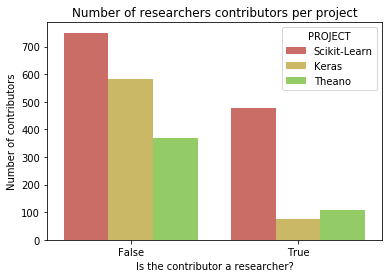

In [13]:
sns.countplot('IS_RESEARCHER', hue = 'PROJECT', data = all_datasets.drop_duplicates(['PROJECT', 'AUTHOR_NAME']))

plt.title('Number of researchers contributors per project')
plt.xlabel('Is the contributor a researcher?')
plt.ylabel('Number of contributors');

In [14]:
def researcher_contributors(project_name, project_dataset):
    without_duplicates = project_dataset.drop_duplicates(['AUTHOR_NAME'])
    percents = 100 * without_duplicates.groupby(['IS_RESEARCHER'])['COMMIT_HASH'].count() / len(without_duplicates)
    
    researcher_contributors = '%.2f' % percents[True]
    non_researcher_contributors = '%.2f' % percents[False]
    unknown = '%.2f' % (100 - percents[True] - percents[False])
    
    print('Participation (in # of contributors) for project \'' + project_name + '\', there has been:')
    print(' -     Researcher contributors:', researcher_contributors + '%')
    print(' - Non researcher contributors:', non_researcher_contributors + '%')
    print(' -            Unknown category:', unknown + '%')

researcher_contributors('Scikit', scikit_dataset)
print()
researcher_contributors('Keras', keras_dataset)
print()
researcher_contributors('Theano', theano_dataset)

Participation (in # of contributors) for project 'Scikit', there has been:
 -     Researcher contributors: 38.97%
 - Non researcher contributors: 61.03%
 -            Unknown category: 0.00%

Participation (in # of contributors) for project 'Keras', there has been:
 -     Researcher contributors: 11.65%
 - Non researcher contributors: 88.35%
 -            Unknown category: 0.00%

Participation (in # of contributors) for project 'Theano', there has been:
 -     Researcher contributors: 22.90%
 - Non researcher contributors: 77.10%
 -            Unknown category: 0.00%


## Les contributions viennent-elles majoritairement de contributeurs académiques ?

### En nombre de *commits*

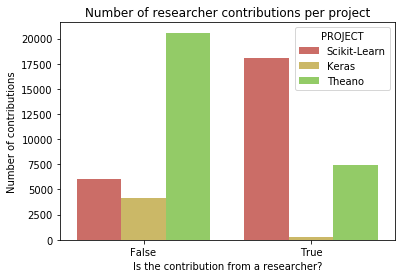

In [15]:
sns.countplot('IS_RESEARCHER', hue = 'PROJECT', data = all_datasets)

plt.title('Number of researcher contributions per project')
plt.xlabel('Is the contribution from a researcher?')
plt.ylabel('Number of contributions');

In [16]:
def researcher_commits_contributions(project_name, project_dataset):
    percents = 100 * project_dataset.groupby(['IS_RESEARCHER']).size() / len(project_dataset)
    
    researcher_contribution = '%.2f' % percents[True]
    non_researcher_contribution = '%.2f' % percents[False]
    unknown = '%.2f' % (100 - percents[True] - percents[False])
    
    print('Participation (in # of commits) for project \'' + project_name + '\', there has been:')
    print(' -     Researcher contributors:', researcher_contribution + '%')
    print(' - Non researcher contributors:', non_researcher_contribution + '%')
    print(' -            Unknown category:', unknown + '%')

researcher_commits_contributions('Scikit', scikit_dataset)
print()
researcher_commits_contributions('Keras', keras_dataset)
print()
researcher_commits_contributions('Theano', theano_dataset)

Participation (in # of commits) for project 'Scikit', there has been:
 -     Researcher contributors: 75.08%
 - Non researcher contributors: 24.92%
 -            Unknown category: -0.00%

Participation (in # of commits) for project 'Keras', there has been:
 -     Researcher contributors: 6.07%
 - Non researcher contributors: 93.93%
 -            Unknown category: 0.00%

Participation (in # of commits) for project 'Theano', there has been:
 -     Researcher contributors: 26.55%
 - Non researcher contributors: 73.45%
 -            Unknown category: 0.00%


### En nombre de lignes ajoutées/retirées

In [17]:
def researcher_lines_contributions(project_name, project_dataset, field):
    percents = 100 * project_dataset.groupby(['IS_RESEARCHER'])[field].sum() / project_dataset[field].sum()
    
    researcher_contribution = '%.2f' % percents[True]
    non_researcher_contribution = '%.2f' % percents[False]
    unknown = '%.2f' % (100 - percents[True] - percents[False])
    
    print('Participation (in # of ' + field + ') for project \'' + project_name + '\', there has been:')
    print(' -     Researcher contributors:', researcher_contribution + '%')
    print(' - Non researcher contributors:', non_researcher_contribution + '%')
    print(' -            Unknown category:', unknown + '%')

def researcher_added_lines_contributions(project_name, project_dataset):
    researcher_lines_contributions(project_name, project_dataset, 'ADDED_LINES')
    
def researcher_deleted_lines_contributions(project_name, project_dataset):
    researcher_lines_contributions(project_name, project_dataset, 'DELETED_LINES')
    
researcher_added_lines_contributions('Scikit', scikit_dataset)
print()
researcher_added_lines_contributions('Keras', keras_dataset)
print()
researcher_added_lines_contributions('Theano', theano_dataset)

print()
print()

researcher_deleted_lines_contributions('Scikit', scikit_dataset)
print()
researcher_deleted_lines_contributions('Keras', keras_dataset)
print()
researcher_deleted_lines_contributions('Theano', theano_dataset)

Participation (in # of ADDED_LINES) for project 'Scikit', there has been:
 -     Researcher contributors: 81.24%
 - Non researcher contributors: 18.76%
 -            Unknown category: 0.00%

Participation (in # of ADDED_LINES) for project 'Keras', there has been:
 -     Researcher contributors: 3.82%
 - Non researcher contributors: 96.18%
 -            Unknown category: 0.00%

Participation (in # of ADDED_LINES) for project 'Theano', there has been:
 -     Researcher contributors: 39.13%
 - Non researcher contributors: 60.87%
 -            Unknown category: 0.00%


Participation (in # of DELETED_LINES) for project 'Scikit', there has been:
 -     Researcher contributors: 78.45%
 - Non researcher contributors: 21.55%
 -            Unknown category: -0.00%

Participation (in # of DELETED_LINES) for project 'Keras', there has been:
 -     Researcher contributors: 4.04%
 - Non researcher contributors: 95.96%
 -            Unknown category: 0.00%

Participation (in # of DELETED_LINES) for p

## Les contributeurs académiques sont-ils les contributeurs qui contribuent le plus  individuellement ?

### En nombre de *commits* par contributeur

In [18]:
# TODO

### En nombre de fichiers modifiés par *commit*

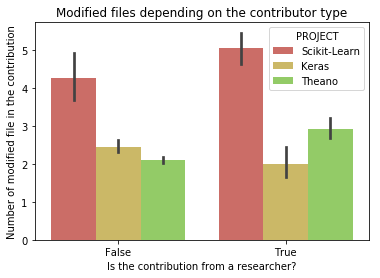

In [19]:
sns.barplot(x = 'IS_RESEARCHER', y = 'MODIFICATIONS_COUNT', hue = 'PROJECT', data = all_datasets)

plt.title('Modified files depending on the contributor type')
plt.xlabel('Is the contribution from a researcher?')
plt.ylabel('Number of modified file in the contribution');

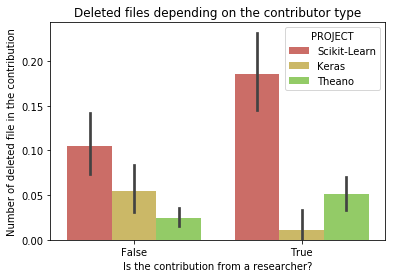

In [20]:
sns.barplot(x = 'IS_RESEARCHER', y = 'DELETED_FILES', hue = 'PROJECT', data = all_datasets)

plt.title('Deleted files depending on the contributor type')
plt.xlabel('Is the contribution from a researcher?')
plt.ylabel('Number of deleted file in the contribution');

### En nombre de lignes ajoutées/retirées par *commit*

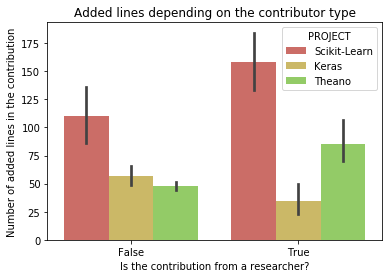

In [21]:
sns.barplot(x = 'IS_RESEARCHER', y = 'ADDED_LINES', hue = 'PROJECT', data = all_datasets)

plt.title('Added lines depending on the contributor type')
plt.xlabel('Is the contribution from a researcher?')
plt.ylabel('Number of added lines in the contribution');

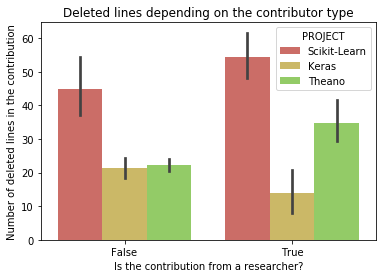

In [22]:
sns.barplot(x = 'IS_RESEARCHER', y = 'DELETED_LINES', hue = 'PROJECT', data = all_datasets)

plt.title('Deleted lines depending on the contributor type')
plt.xlabel('Is the contribution from a researcher?')
plt.ylabel('Number of deleted lines in the contribution');